In [4]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [5]:
# --- 1) Carregar dados e seleção de features ------------------------------
df = pd.read_csv('data/tripadvisor_european_restaurants.csv')
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df_num = df[numeric_cols].dropna()
X = df_num.values

# Padronizar
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

C:\Users\Thiago\AppData\Local\Temp\ipykernel_9240\166970479.py:2: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/tripadvisor_european_restaurants.csv')


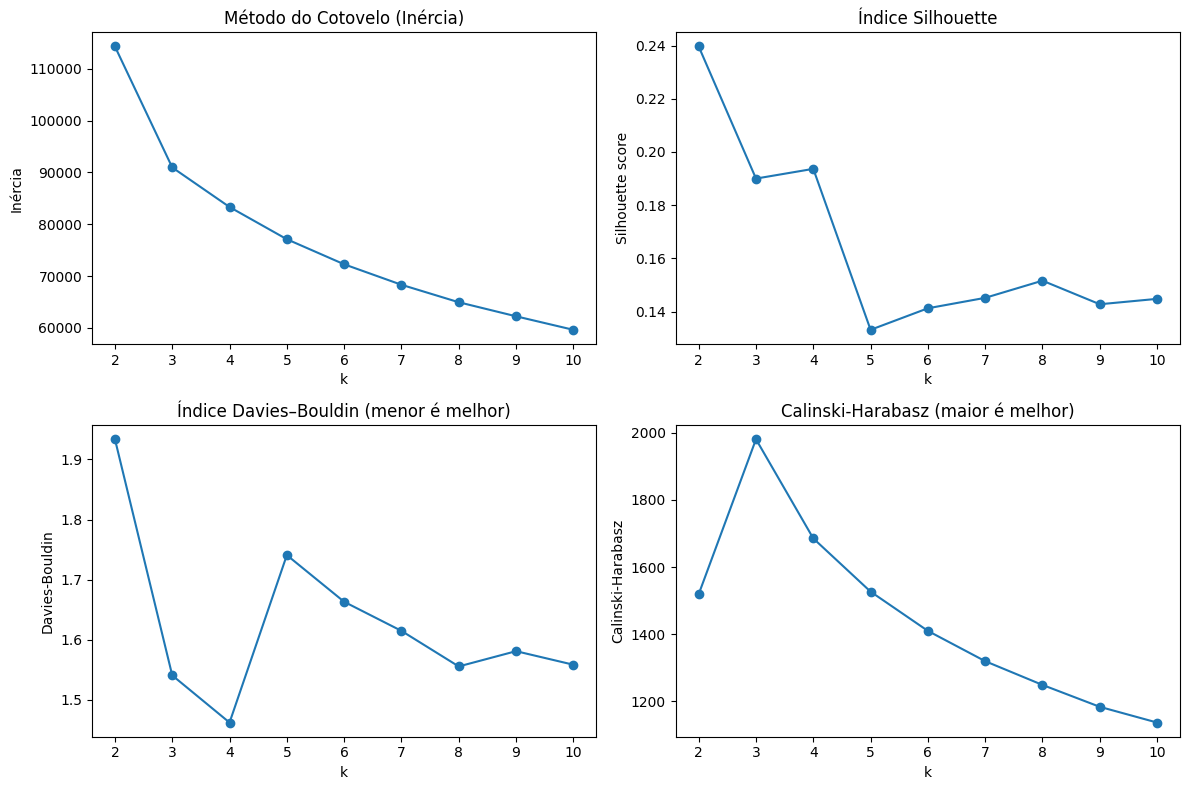

In [7]:
# --- 2) Amostragem inteligente para acelerar a análise K-ideal -----------
# Amostra estratificada seria ideal, mas simples aleatória já atende o projeto

df_sample = df_num.sample(n=8000, random_state=0)   # 8 mil já é rápido e suficiente
X_s = scaler.fit_transform(df_sample.values)

ks = range(2, 11)
inertias = []
sil_scores = []
db_scores = []
ch_scores = []

for k in ks:
    km = KMeans(n_clusters=k, random_state=0, n_init=5)  # reduzir n_init = mais rápido
    labels = km.fit_predict(X_s)

    inertias.append(km.inertia_)
    sil_scores.append(silhouette_score(X_s, labels))
    db_scores.append(davies_bouldin_score(X_s, labels))
    ch_scores.append(calinski_harabasz_score(X_s, labels))

# Plotar métricas
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.plot(ks, inertias, 'o-')
plt.title('Método do Cotovelo (Inércia)')
plt.xlabel('k')
plt.ylabel('Inércia')

plt.subplot(2,2,2)
plt.plot(ks, sil_scores, 'o-')
plt.title('Índice Silhouette')
plt.xlabel('k')
plt.ylabel('Silhouette score')

plt.subplot(2,2,3)
plt.plot(ks, db_scores, 'o-')
plt.title('Índice Davies–Bouldin (menor é melhor)')
plt.xlabel('k')
plt.ylabel('Davies-Bouldin')

plt.subplot(2,2,4)
plt.plot(ks, ch_scores, 'o-')
plt.title('Calinski-Harabasz (maior é melhor)')
plt.xlabel('k')
plt.ylabel('Calinski-Harabasz')

plt.tight_layout()
plt.show()

In [8]:
# --- 3) Escolher K (ex: baseado nas métricas, escolha k_opt) -------------
# Sugestão: leia os gráficos e escolha um k. Aqui usamos uma heurística:
k_opt = int(input("Escolha o k ótimo (baseado nos gráficos acima), por exemplo 3,4,5: ") or 3)

km_final = KMeans(n_clusters=k_opt, random_state=0, n_init=10)
labels_final = km_final.fit_predict(X_std)

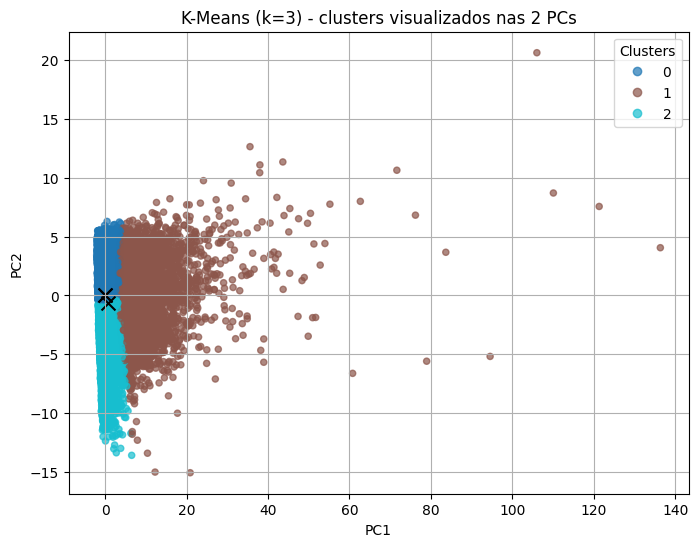

In [9]:
# --- 4) Visualizar clusters em 2D usando PCA (sklearn PCA)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj2 = pca.fit_transform(X_std)

plt.figure(figsize=(8,6))
scatter = plt.scatter(proj2[:,0], proj2[:,1], c=labels_final, cmap='tab10', s=20, alpha=0.7)
plt.scatter(km_final.cluster_centers_[:,0], km_final.cluster_centers_[:,1], marker='x', color='k', s=100, label='Centroides (no espaço padronizado)')
plt.title(f'K-Means (k={k_opt}) - clusters visualizados nas 2 PCs')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.show()

In [10]:
# --- 5) Estatísticas dos clusters (tabela resumida) -----------------------
df_out = df_num.copy()
df_out['cluster'] = labels_final
summary = df_out.groupby('cluster').agg(['mean','count'])
display(summary)

latitude         longitude         open_days_per_week          \
              mean   count      mean   count               mean   count   
cluster                                                                   
0        46.461128  122587  5.181901  122587           6.191537  122587   
1        50.549840   11256 -0.039129   11256           6.735963   11256   
2        46.843784   65699  5.198080   65699           6.655992   65699   

        open_hours_per_week         working_shifts_per_week          ...  \
                       mean   count                    mean   count  ...   
cluster                                                              ...   
0                 54.171848  122587                7.959139  122587  ...   
1                 71.845965   11256                7.468284   11256  ...   
2                 69.797294   65699                8.516614   65699  ...   

          terrible              food           service             value  \
              mean   count      mean   count      mean   count      mean   
cluster                                                                    
0         3.577361  122587  4.356114  122587  4.305204  122587  4.195131   
1        61.230277   11256  4.068319   11256  4.051883   11256  3.880020   
2         8.793604   65699  3.665771   65699  3.593966   65699  3.500540   

                atmosphere          
          count       mean   count  
cluster                             
0        122587   4.196501  122587  
1         11256   3.991427   11256  
2         65699   3.525343   65699  

[3 rows x 34 columns]